## Imports and data loading

In [1]:
# General
import os
import sys
import subprocess
import copy

# Dataset management
import datalad.api as dl

# Data handling
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io 

# BIDS dataset handling
# from bids import BIDSLayout

# Network / Graph
import pygsp
import networkx as nx

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import nilearn
from nilearn import plotting, image, datasets

# Load Data
data = scipy.io.loadmat("nhw2022-network-harmonics-data.mat")

print("Data keys:")
print(list(data.keys()))
print("Age data:")
pd.DataFrame(data['age']).describe()


Data keys:
['__header__', '__version__', '__globals__', 'age', 'nets', 'None', 'yeoLabs', '__function_workspace__']
Age data:


,0
count,594.000000
mean,53.557239
std,18.158686
min,18.000000
25%,38.000000
50%,53.000000
75%,69.000000
max,88.000000


In [2]:

# strip the ages from the list
ages_squeezed = np.squeeze(data['age'])

# sort ages (without storing the indexes) to use as labels 
sorted_ages = np.sort(ages_squeezed)
    
# order by age and get the indexes from the former list linked to each element in this new list
idxs = np.argsort(ages_squeezed)

# sort the networks (connectomes) and graph Laplacian by age
'''WARNING: the indexing is inverted in these two (for what I could figure from some cells below; you
can find it by searching (ctrl+f) for the words "shazam" and "alakazam" respe'''
sorted_nets = data['nets'][:,:,idxs]
# sorted_harmonics = harmonics[idxs,:,:]

# Change dimensions of matrices. sorted_nets is all the adjacency matrices sorted by age. 
# This changes it so the first dimension is each subject and the others are the matrices
sorted_nets = np.moveaxis(sorted_nets,2,0)


In [4]:
# Binarize adjacency matrices

# binarized_sorted_nets = sorted_nets

# for matrix in range(binarized_sorted_nets.shape[0]):
#     boolean_matrix = binarized_sorted_nets[matrix,:,:] > 0
#     binarized_matrix = boolean_matrix.astype(int)
#     binarized_sorted_nets[matrix,:,:] = binarized_matrix



In [3]:
test_subject = sorted_nets[500]

TypeError: 'builtin_function_or_method' object is not subscriptable

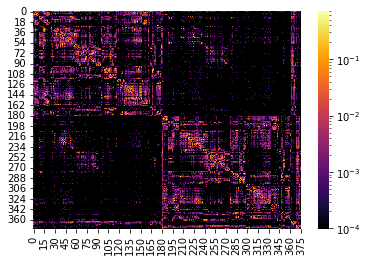

In [3]:
# Create color map to handle zeros with log visualization
custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))

# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))
sns.heatmap(data['nets'][:,:,570], cmap = custom_cmap, norm=LogNorm())
sns.heatmap(sorted[:,:,570], cmap = custom_cmap, norm=LogNorm())


# sns.color_palette("viridis", as_cmap=True)
# heatmap = sns.heatmap(data['nets'][:,:,0], norm=LogNorm())
# heatmap.set(axis_bgcolor='k')



### Count 0's in original adjacency matrices


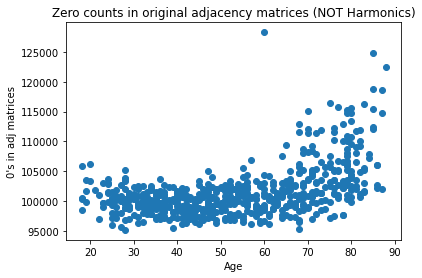

In [4]:
sorted_nets.shape
test_subject = sorted_nets[570,:,:]


zeros_in_adj_matrices = np.zeros(sorted_ages.shape[0])

zeros = np.where(test_subject == 0)
# print(zeros[0].size)

for subject in range(sorted_ages.shape[0]):
    zeros_in_adj_matrices[subject] = np.where(sorted_nets[subject,:,:] == 0)[0].size

plt.scatter(sorted_ages, zeros_in_adj_matrices)
plt.title("Zero counts in original adjacency matrices (NOT Harmonics)")
plt.xlabel("Age")
plt.ylabel("0's in adj matrices")
plt.show()


(array([22., 58., 72., 66., 74., 61., 66., 70., 71., 34.]),
 array([18., 25., 32., 39., 46., 53., 60., 67., 74., 81., 88.]),
 <BarContainer object of 10 artists>)

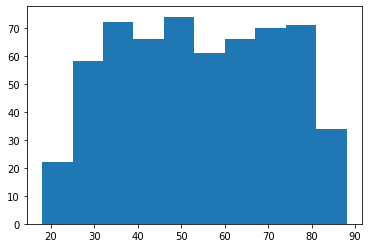

In [5]:
plt.hist(sorted_ages)

## Calculate Connectome Harmonics CHANGED FOR BINARIZED MATRICES


In [6]:
'''
NOTE 
I changed this to binarized matrices!!  
'''

# Create blank matrices to be filled by harmonics
harmonics = np.zeros(sorted_nets.shape)
graphs = []

'''
I think this might be more code than we need. I think G_fd.U might be enough to return the eigenvectors of the laplacian.

Also, I think that 'graphs' and 'harmonics' might be different graphs because it's not assigning new variables to G_fd. 
Later in the code both 'graphs' and 'harmonics' are analyized, so we might be analyzing different graphs and thinking 
they are the same!
'''

# Compute connectome harmonics from adjacency matrices

for i in range(len(sorted_nets)):

        subject = sorted_nets[i,:,:]
        # subject = binarized_sorted_nets[i,:,:]


        np.fill_diagonal(subject, 0)  # PyGSP does not support self-loops

        G_fd = pygsp.graphs.Graph(subject)  # PyGSP graph
        G_fd.compute_laplacian(lap_type = "normalized")
        G_fd.compute_fourier_basis()  # compute connectome harmonics

        graphs.append(G_fd)


    
        harmonics[i,:,:] = G_fd.U


# graphs[480].e


c:\Users\liqui\anaconda3\envs\ML\lib\site-packages\pygsp\graphs\graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [7]:
type(graphs[1].W)
# print(graphs[0].W)

test_graph = graphs[1].W

  (0, 1)	0.017125
  (0, 2)	0.00076075
  (0, 3)	0.035117
  (0, 4)	0.0025773
  (0, 5)	0.0064113
  (0, 6)	0.0017173
  (0, 8)	0.02039
  (0, 9)	0.0038118
  (0, 10)	0.012107
  (0, 11)	0.0055523
  (0, 12)	0.007571
  (0, 13)	0.003741
  (0, 14)	0.084052
  (0, 15)	0.05107
  (0, 16)	0.00076031
  (0, 17)	0.0058887
  (0, 18)	0.0013479
  (0, 19)	0.0015103
  (0, 21)	0.00079554
  (0, 23)	0.00080209
  (0, 24)	0.00040355
  (0, 25)	0.0021602
  (0, 26)	0.0021064
  (0, 27)	0.075734
  (0, 28)	0.00068587
  (0, 29)	0.037177
  (0, 30)	0.062192
  (0, 31)	0.04086
  (0, 32)	0.003885
  (0, 33)	0.030035
  (0, 34)	0.010788
  (0, 35)	0.0069124
  (0, 36)	0.046726
  (0, 37)	0.14184
  (0, 38)	0.030622
  (0, 39)	0.020582
  (0, 40)	0.13762
  (0, 41)	0.10089
  (0, 42)	0.0072939
  (0, 43)	0.0057554
  (0, 44)	0.0034448
  (0, 45)	0.0070101
  (0, 46)	0.009487
  (0, 47)	0.004166
  (0, 48)	0.0069553
  (0, 49)	0.0027816
  (0, 50)	0.010542
  (0, 51)	0.0023167
  (0, 52)	0.011548
  (0, 53)	0.012774
  (0, 54)	0.0066541
  (0, 55)	0.00

## Calculate Entropy for each harmonic and generate analytic data

In [7]:

from scipy.stats import entropy

# Create matrix for entropy for 594 subjects and 376 harmonics per subject.
entropia = np.zeros((594, 376))

# Create matrix for storing values and counts of each harmonic
values_list = []
counts_list = []


# Loop through each harmonic for each subject to calculate entropy and record eigenvector values and counts

for subject in range(harmonics.shape[0]):

    # This if statement prints out every 100 subjects to assess how long the loop is taking
    if subject % 100 == 0:
        print("Computing entropy for subject number ", subject)

    # Empty matrices for storing entropy for the subject and roudned values in order to take counts of those values
    subject_entropy = np.zeros(376)
    rounded_values = np.zeros(376*1, dtype=int)

    subject_values = []
    subject_counts = []


    # Loop through every harmonic for this subject

    for harmonic in range(harmonics.shape[1]):

        harmonic_entropy = 0
        # harmonic_values = []
        # harmonic_counts = []

        # Loop through every eigenvector element for this harmonic. Round the values and take counts of how many times
        # each value occurs in that harmonic

        for eigenvector_element in range(0, 376):
       
            rounded_values[eigenvector_element] = int(harmonics[subject, harmonic, eigenvector_element] * 100.)

        values, counts = np.unique(rounded_values, return_counts=True)
    
        # Store values and counts in lists for further analysis

        subject_values.append(values.tolist())
        subject_counts.append(counts.tolist())

        # Calculate entropy for each harmonic 
        harmonic_entropy = entropy(counts, base=2)
        subject_entropy[harmonic] = harmonic_entropy


    # Store vectors of values and counts for all the subject's harmonics to lists
    values_list.append(subject_values)
    counts_list.append(subject_counts)    

    # Store entropy for all subject's harmonics in entropia matrix
    entropia[subject][:] = subject_entropy

# print("Done.")

Computing entropy for subject number  0
Computing entropy for subject number  100
Computing entropy for subject number  200
Computing entropy for subject number  300
Computing entropy for subject number  400
Computing entropy for subject number  500


In [8]:


# For the counts list, the first index is the subject and the second is the harmonic

# Find which value has maximum count in each harmonic for each subject. If any are not 0, report
# The result is that for every harmonic for every subject 0 is the most occuring value

for subject in range(len(counts_list)):

    for harmonic in range(len(counts_list[subject])):

        max_value_count = values_list[subject][harmonic][counts_list[subject][harmonic].index(max(counts_list[subject][harmonic]))]
        if max_value_count != 0:
            print(subject, harmonic)


zero_counts = np.zeros((len(counts_list), len(counts_list[0])))
print(zero_counts.shape)

# For each haromnic for each subject, count the number of 0 values in the eigenvector

for subject in range(len(counts_list)):
    for harmonic in range(len(counts_list[0])):
        zero_counts[subject,harmonic] = max(counts_list[subject][harmonic])



(594, 376)


# Plotting

In [ ]:
'''This cell is for combining pdf pages into one'''


from PyPDF2 import PdfMerger
import os

directory = './Figures/zero_counts/'

pdfs = []


for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if os.path.isfile(f):
        pdfs.append(f)

merger = PdfMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write("zero_counts.pdf")
merger.close()

### Plot zero counts

NameError: name 'zero_counts' is not defined

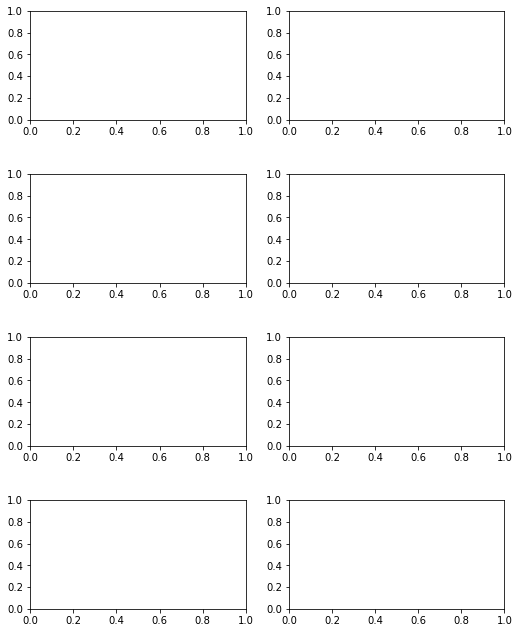

In [25]:

''' This cell plots all the 0 counts for each subject's harmonic's eigenvector for each age
    then generates a single pdf with all the plots'''


harmonics_to_analyze = 40

from matplotlib.backends.backend_pdf import PdfPages
harmonic = 0

while harmonic < harmonics_to_analyze:

    # Initialise the subplot function using number of rows and columns
    figure, axis = plt.subplots(4, 2)
    figure.set_size_inches([8.5, 11])
    figure.subplots_adjust(wspace=0.2, hspace=0.5)

    pp = PdfPages(f'{harmonic:04d} zero_counts_per_harmonic_binarized_matrix.pdf')

    for x_plot in range(4):

        for y_plot in range(2):

            axis[x_plot, y_plot].scatter(sorted_ages, zero_counts[:,harmonic])
            axis[x_plot, y_plot].set_title(f"Counts of 0's eigenvector of harmonic {harmonic}")
            axis[x_plot, y_plot].set_xlabel("Age")
            axis[x_plot, y_plot].set_ylabel("0's in harmonic eigenvector")

            harmonic += 1

    pp.savefig()
    pp.close()
    


### Plot Entropy

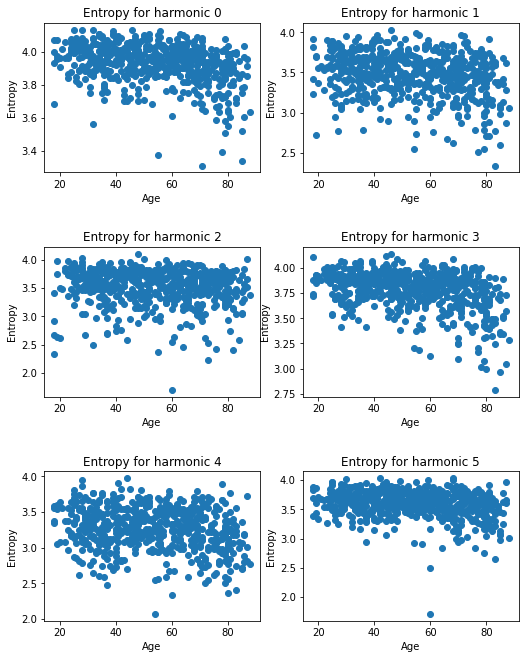

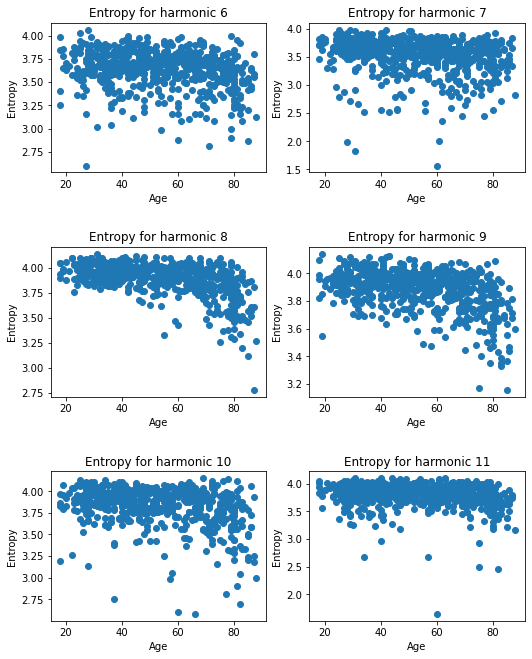

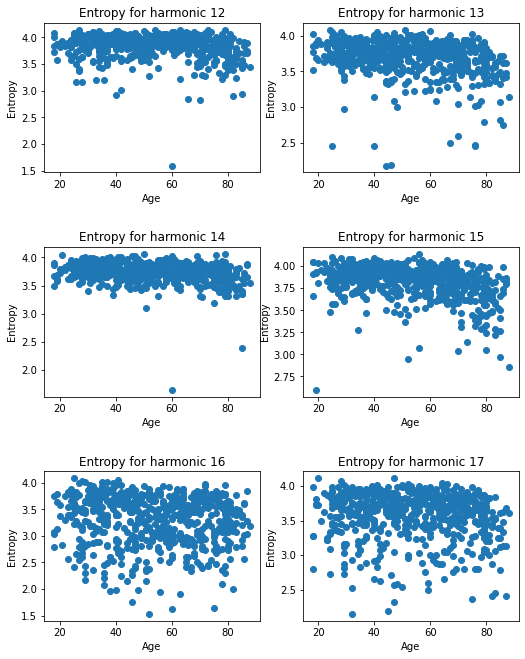

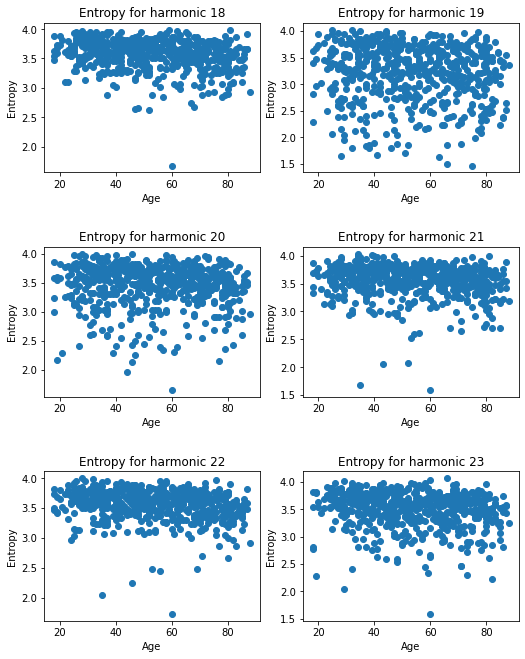

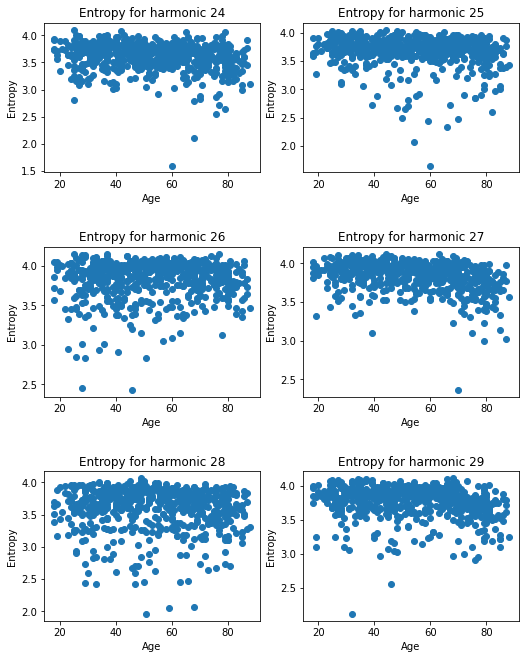

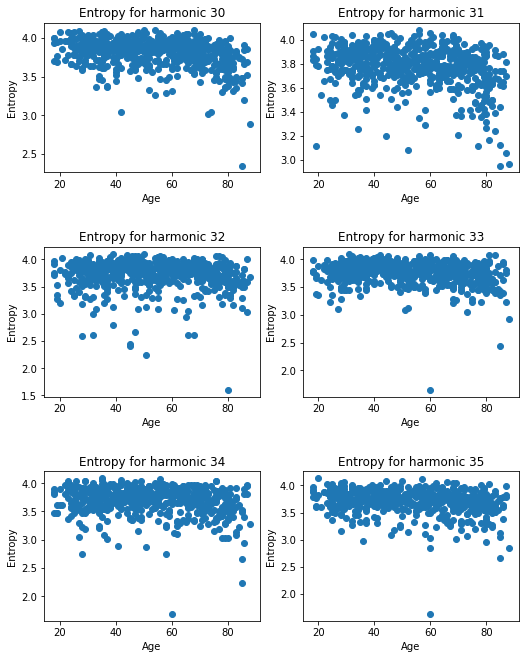

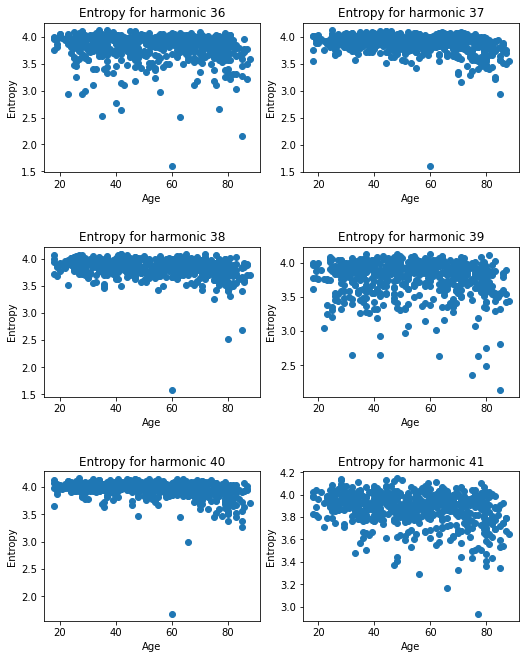

In [9]:
harmonics_to_analyze = 40

from matplotlib.backends.backend_pdf import PdfPages
harmonic = 0

while harmonic < harmonics_to_analyze:

    # Initialise the subplot function using number of rows and columns
    figure, axis = plt.subplots(3, 2)
    figure.set_size_inches([8.5, 11])
    figure.subplots_adjust(wspace=0.2, hspace=0.5)

    pp = PdfPages(f'{harmonic:04d} entropy_per_harmonic_binazried.pdf')

    for x_plot in range(3):

        for y_plot in range(2):

            axis[x_plot, y_plot].scatter(sorted_ages, entropia[:,harmonic])
            axis[x_plot, y_plot].set_title(f"Entropy for harmonic {harmonic}")
            axis[x_plot, y_plot].set_xlabel("Age")
            axis[x_plot, y_plot].set_ylabel("Entropy")

            harmonic += 1

    pp.savefig()
    pp.close()



Average Entropy: 3.9282914025710016
Difference in avg. entropy in youngest and oldest: -0.12567501246663815
Average Entropy: 3.4698251522640495
Difference in avg. entropy in youngest and oldest: -0.20184591994721846
Average Entropy: 3.523580757423238
Difference in avg. entropy in youngest and oldest: -0.08309091996748963
Average Entropy: 3.7725852552524026
Difference in avg. entropy in youngest and oldest: -0.22688007810587418
Average Entropy: 3.2580519654193
Difference in avg. entropy in youngest and oldest: -0.22227344208052546
Average Entropy: 3.5906177523471956
Difference in avg. entropy in youngest and oldest: -0.18221455190775826
Average Entropy: 3.6390172428279968
Difference in avg. entropy in youngest and oldest: -0.15644186623152478
Average Entropy: 3.51406755658558
Difference in avg. entropy in youngest and oldest: -0.1247204560339128
Average Entropy: 3.8919710949496884
Difference in avg. entropy in youngest and oldest: -0.2539095983549964
Average Entropy: 3.8786091368236963


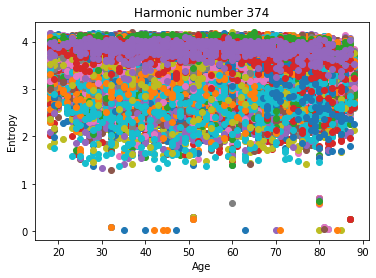

In [10]:


# Differences in Entropy youngest vs oldest 100 subjects

harmonics_to_analyze = 375

differences_of_averages_array = np.zeros(harmonics_to_analyze)

for harmonic in range(harmonics_to_analyze):

    avg_entropy = np.average(entropia[:, harmonic])
    
    difference_of_averages = np.average(entropia[range(492,593), harmonic]) - np.average(entropia[range(0,100), harmonic]) 
    differences_of_averages_array[harmonic] = difference_of_averages

    ''' Confirm the axes are in the right order!!'''
    plt.scatter(sorted_ages, entropia[:,harmonic])
    plt.title("Harmonic number {}".format(harmonic))
    plt.xlabel("Age")
    plt.ylabel("Entropy")
    # plt.show()

    print("Average Entropy:", avg_entropy)
    print("Difference in avg. entropy in youngest and oldest:", difference_of_averages)

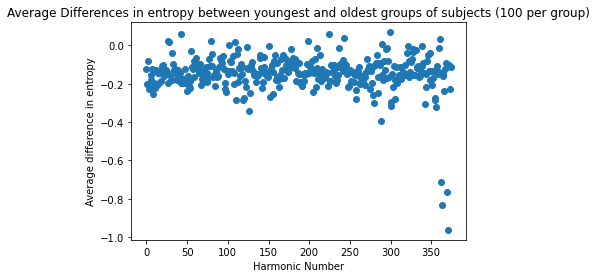

In [10]:
# Calculate average differences in entropy in younger vs older subjects for 
# each harmonic

harmonics_to_display = 375

plt.scatter(range(harmonics_to_display), differences_of_averages_array[range(harmonics_to_display)])
plt.title("Average Differences in entropy between youngest and oldest groups of subjects (100 per group)")
plt.xlabel("Harmonic Number")
plt.ylabel("Average difference in entropy")
plt.show()



In [37]:


subject = 5
harmonic = 7

# print(counts_list[subject][harmonic])
# print(entropia[subject][harmonic])
# print(entropy(counts_list[subject][harmonic], base=2))

original_vector = [1, 1, 2, 1, 3, 3, 2, 2, 6, 6, 5, 6, 17, 21, 21, 37, 133, 25, 25, 14, 13, 11, 5, 4, 2, 1, 1, 1, 1, 1, 3, 1, 1]
test_vector_0 = [9633, 1, 2, 77, 34, 35, 26, 27, 68, 69, 50, 6, 17, 21, 21, 37, 133, 25, 25, 14, 13, 11, 5, 4, 2, 15, 52, 15, 34, 56, 3, 15, 43]
test_vector_1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14, 13, 11, 5, 4, 2, 115, 52, 15, 14, 16, 3, 15, 41]

print("Original vector variance:", np.var(original_vector), "entropy:",entropy(original_vector, base = 2))
print("Test vector 0 (more variance) variance:", np.var(test_vector_0), "entropy:", entropy(test_vector_0, base=2))
print("Test vector 1 (less variance) variance:", np.var(test_vector_1), "entropy:", entropy(test_vector_1, base=2))

Original vector variance: 542.6629935720846 entropy: 3.6164637199898046
Test vector 0 (more variance) variance: 2710608.5913682273 entropy: 0.8394912898532042
Test vector 1 (less variance) variance: 472.3801652892561 entropy: 3.379623760497421


In [40]:
dice = [1, 2, 3, 4, 5, 6]

entropy(dice, base = 2)

2.3983029951155594

## Analysis of harmonic distributions

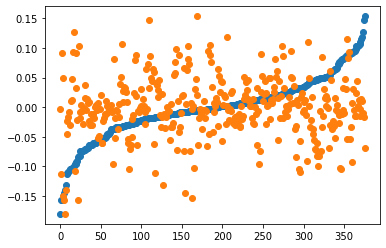

In [11]:
# subject_0 = harmonics[0,:,:]

# test_harmonic = harmonics[0,:,1]

plt.scatter(range(len(harmonics[0,:,2])), np.sort(harmonics[0,:,20]))
plt.scatter(range(len(harmonics[0,:,2])), harmonics[0,:,20])

plt.show()

variance 389.0266299357209
variance 542.9298454221166
variance 305.18222222222215
variance 939.7574316290131
variance 499.5720844811755
variance 333.9188345473464
variance 449.93572084481184
variance 422.11238293444313
variance 1154.4994797086372
variance 510.2906574394463
variance 739.0801248699273
variance 454.9054178145088
variance 422.2414151925077
variance 645.209157127992
variance 393.5
variance 453.01560874089483
variance 354.99653979238747
variance 511.75743162901307
variance 363.87889273356404
variance 566.0478668054113


C:\Users\liqui\AppData\Local\Temp/ipykernel_18112/876837041.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


variance 634.6020408163265
variance 386.29935720844816
variance 431.4508723599633
variance 593.1822222222224
variance 362.5
variance 410.87673469387755
variance 492.8195918367346
variance 923.9188345473466
variance 442.8448117539027
variance 387.0
variance 402.7024221453288
variance 875.25
variance 502.4626038781165
variance 698.4083044982699
variance 435.4488888888889
variance 356.70242214532874
variance 603.58024691358
variance 572.8220603537983
variance 415.33818938605594
variance 528.5259515570933


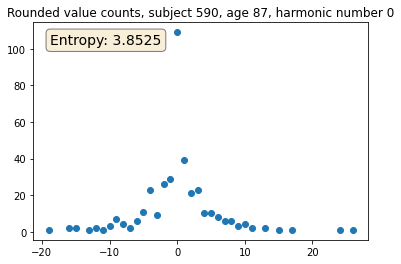

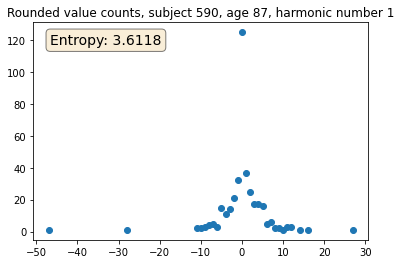

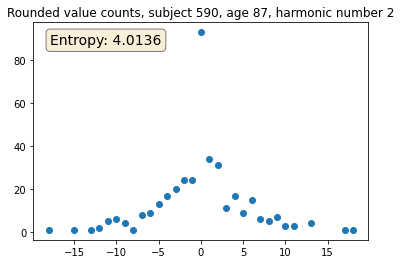

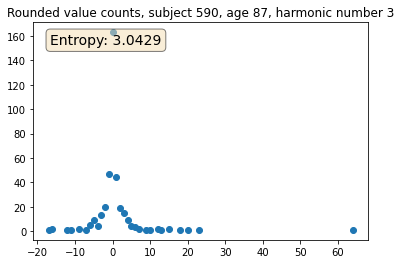

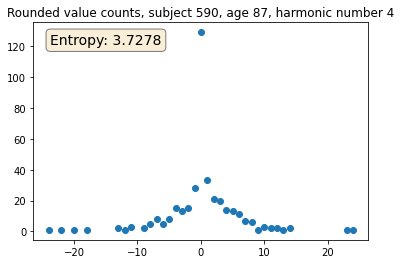

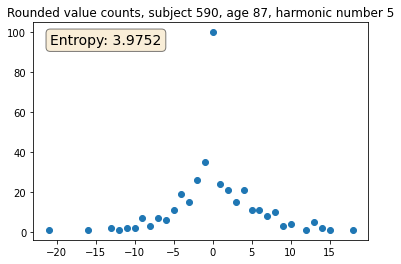

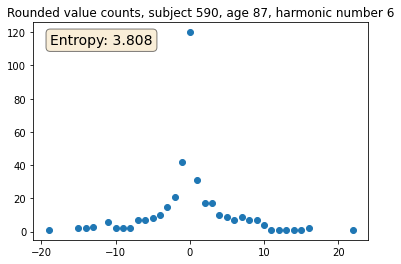

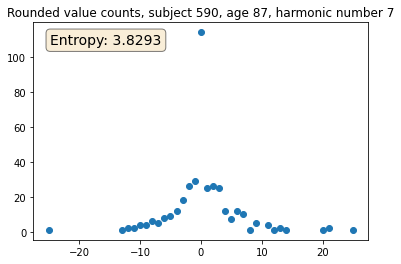

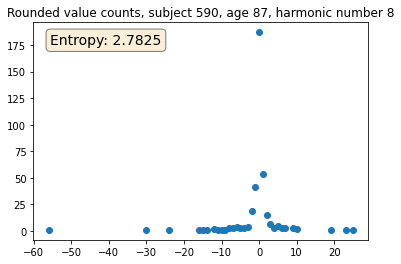

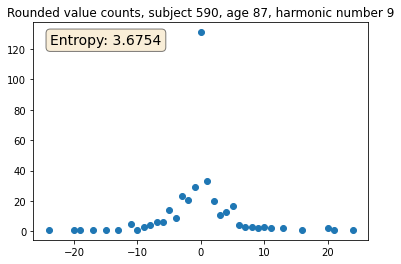

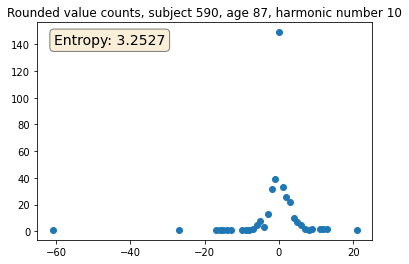

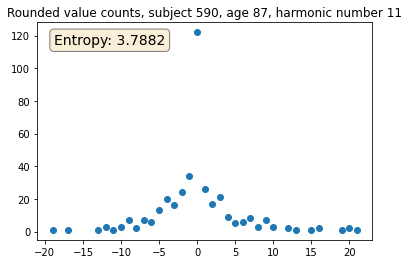

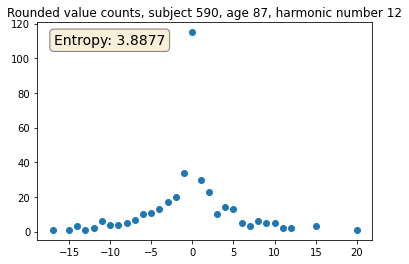

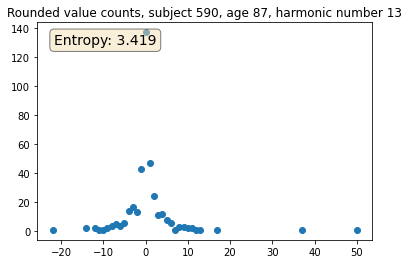

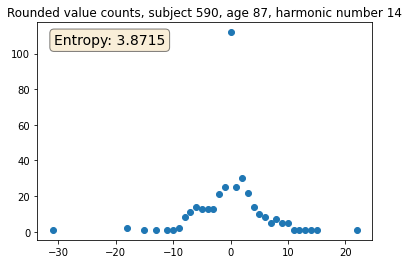

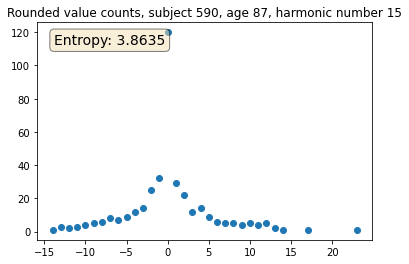

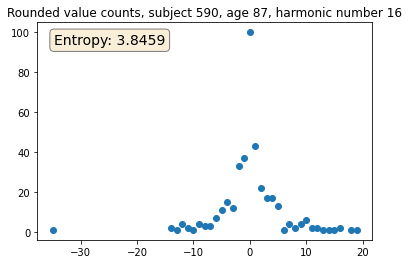

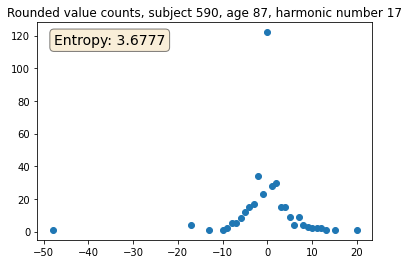

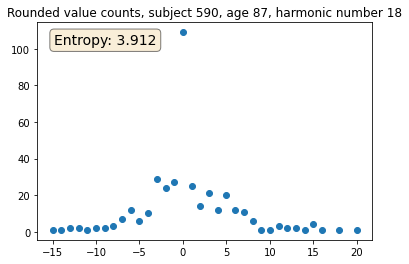

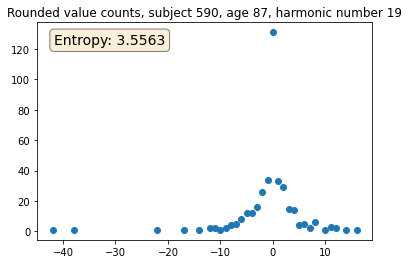

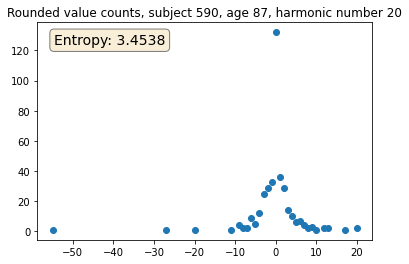

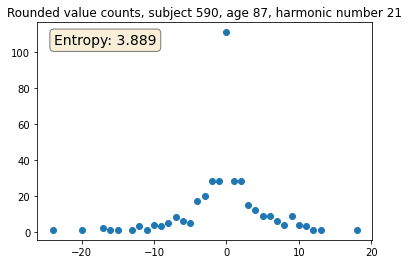

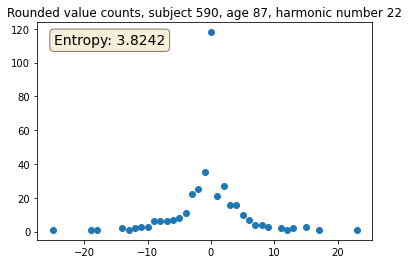

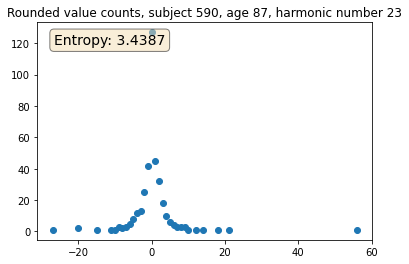

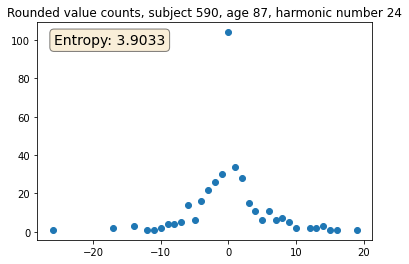

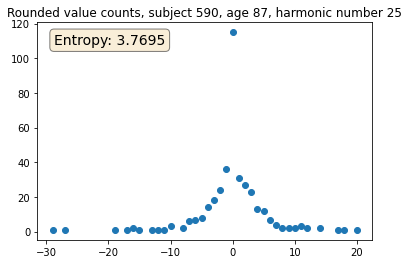

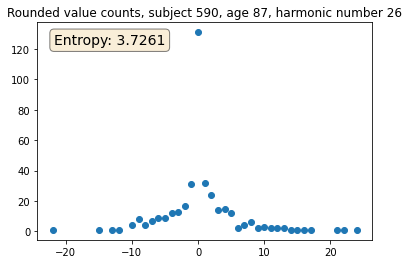

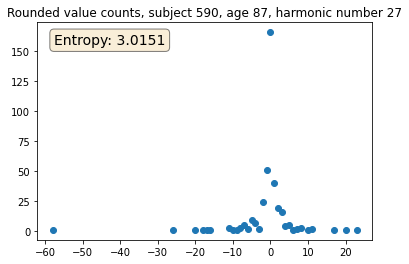

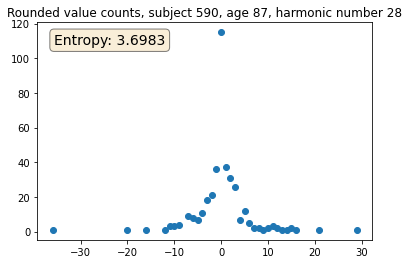

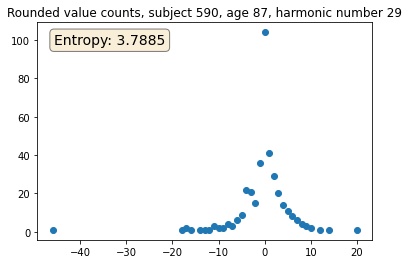

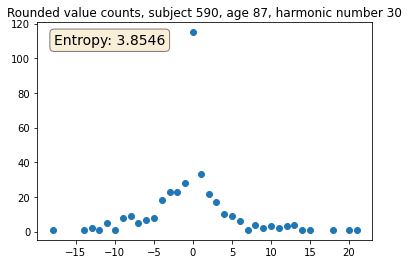

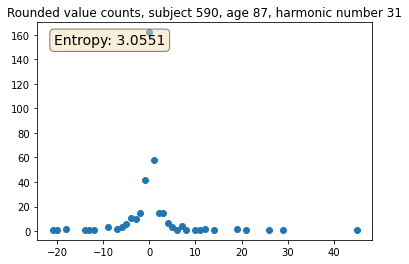

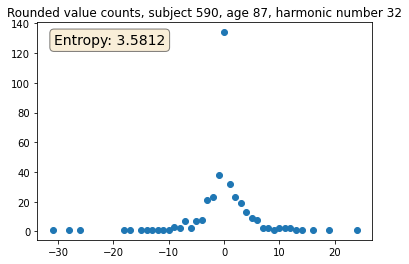

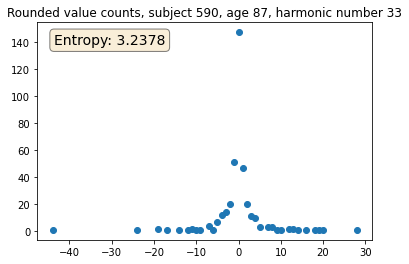

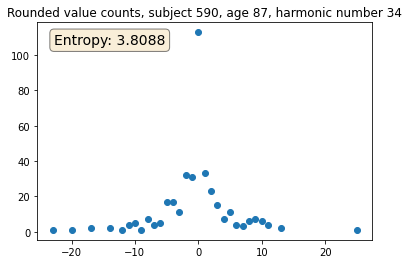

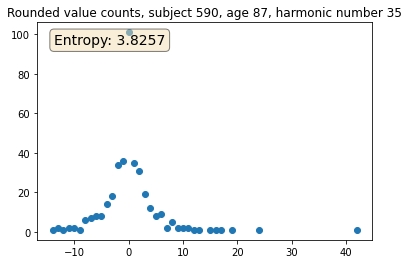

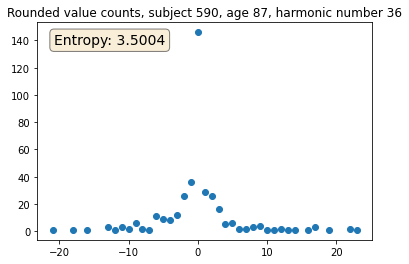

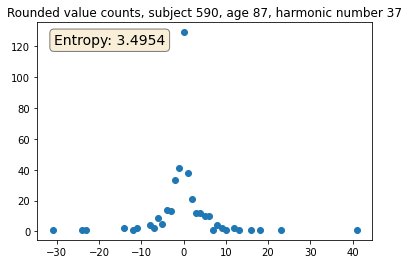

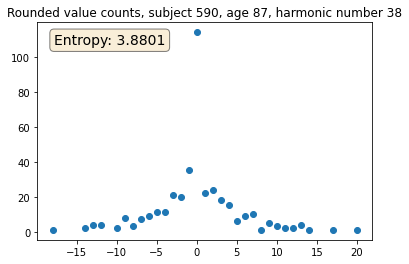

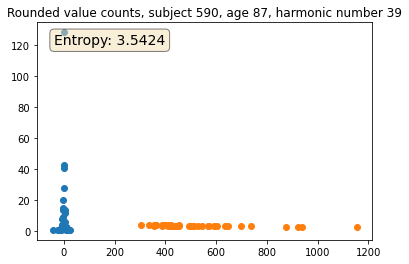

In [78]:
# For the counts and values list, the first index is the subject and the second is the harmonic's counts, which is a list.

from scipy.stats import entropy
from matplotlib.offsetbox import AnchoredText

low_harm_bound_to_analyze = 0
high_harm_bound_to_analyze = 40

subject = 590
subject = int(subject)
age = sorted_ages[subject]

# for harmonic in range(low_harm_bound_to_analyze, high_harm_bound_to_analyze):
#     plt.scatter(values_list[subject][harmonic], counts_list[subject][harmonic])
#     plt.title(f"Rounded value counts, subject {subject}, age {age}, harmonics {low_harm_bound_to_analyze} to {high_harm_bound_to_analyze}")
#     plt.xlabel("Rounded Value in harmonic's Eigenvector")
#     plt.ylabel("Count of value")


#     # plt.text(0.1, 0.9, "Text")

#     # anchored_text = AnchoredText("Test", loc='lower left', prop=dict(size=8), frameon=True,
#     #                    bbox_to_anchor=(0., 1.),
#     #                    bbox_transform=ax.transAxes)
#     # plt.add_artist(anchored_text)

#     plt.show()

#     counts_np_arr = np.array(counts_list[subject][harmonic])

#     harmonic_entropy = entropy(counts_np_arr, base=2)
#     print(harmonic_entropy)

entropy_list = []
variance_list = []


for harmonic in range(low_harm_bound_to_analyze, high_harm_bound_to_analyze):
    fig, ax = plt.subplots()

    ax.scatter(values_list[subject][harmonic], counts_list[subject][harmonic])
    # ax.title(f"Rounded value counts, subject {subject}, age {age}, harmonics {low_harm_bound_to_analyze} to {high_harm_bound_to_analyze}")
    # ax.ad("Rounded Value in harmonic's Eigenvector")
    # ax.ylabel("Count of value")

    ax.title.set_text(f"Rounded value counts, subject {subject}, age {age}, harmonic number {harmonic}")

    counts_np_arr = np.array(counts_list[subject][harmonic])

    harmonic_entropy = entropy(counts_np_arr, base=2)
    entropy_string = str(round(harmonic_entropy, 4))

    variance = np.var(counts_np_arr)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    overlay_text = f"Entropy: {entropy_string}"


    ax.text(0.05, 0.95, overlay_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    # plt.text(0.1, 0.9, "Text")

    # anchored_text = AnchoredText("Test", loc='lower left', prop=dict(size=8), frameon=True,
    #                    bbox_to_anchor=(0., 1.),
    #                    bbox_transform=ax.transAxes)
    # ax.add_artist(anchored_text)

    # plt.show()

    entropy_list.append(harmonic_entropy)
    variance_list.append(variance)

    print("variance", np.var(counts_np_arr))


plt.scatter(variance_list, entropy_list)


Text(0, 0.5, 'Entropy')

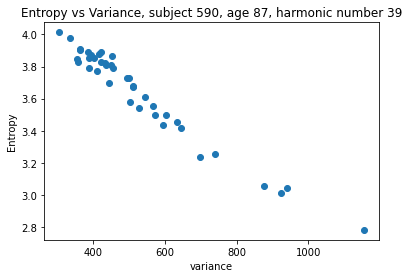

In [81]:

plt.scatter(variance_list, entropy_list)
plt.title(f"Entropy vs Variance of counts, subject {subject}, age {age}, harmonic number {harmonic}")
plt.xlabel("variance")
plt.ylabel("Entropy")

In [ ]:
print(len(values_list))
print(values_list[0])

In [ ]:


plt.hist(values)
plt.show()

print(values.shape)

plt.scatter(values, range(375))
plt.show()


plt.hist(counts)
plt.show()


In [8]:
# graphs[480].U
# scipy.stats.entropy(graphs[480].U)

test_arr = [1, 1, 1, 4, 7]

test_values, test_counts = np.unique(test_arr,return_counts=True)
entropia_test = entropy(test_counts,base=2)
print(entropia_test)

1.370950594454669


In [23]:
# Ramon's code

from scipy.stats import entropy
entropia=np.zeros(594)
for subject in range(594):
    array=np.zeros(376*376,dtype=int)
    cont=-1
    add=0
    for xx in range(376):
        for yy in range(0,376):
            cont=cont+1
            array[cont]=int(harmonic[xx,yy,subject]*100.)
    values,counts = np.unique(array,return_counts=True)
    entropia[subject] = entropy(counts,base=2)
    #print(subject,"-------------------------------------------",counts.size)
print("done")


shannon1=np.zeros(594)
shannon2=np.zeros(594)
for harm in range(0,20):
    x = ages
    for subject in range(594):
        shannon1[subject]=eigenvalues[harm,subject]
        shannon2[subject]=entropia[subject,harm]
    print("eigenvalue","eigenvector",harm)
    plt.subplot(1, 2, 1)
    plt.scatter(x,shannon1)
    #plt.title('eigenvalues')
    plt.xlabel('age')
    plt.ylabel('eigenvalue')
    plt.subplot(1, 2, 2)
    plt.scatter(x,shannon2)
    #plt.title('entropy of the eigenvector')
    plt.xlabel('age')
    plt.ylabel('entropy of corresponding eigenvector')
    plt.tight_layout()
    plt.show()
print("done")

NameError: name 'harmonic' is not defined

In [ ]:
shannon2=np.zeros(594)
for harm in range(0,20):
    x = ages
    for subject in range(594):
        shannon1[subject]=eigenvalues[harm,subject]
        shannon2[subject]=entropia[subject,harm]
    print("eigenvalue","eigenvector",harm)
    plt.subplot(1, 2, 1)
    plt.scatter(x,shannon1)
    #plt.title('eigenvalues')
    plt.xlabel('age')
    plt.ylabel('eigenvalue')
    plt.subplot(1, 2, 2)
    plt.scatter(x,shannon2)
    #plt.title('entropy of the eigenvector')
    plt.xlabel('age')
    plt.ylabel('entropy of corresponding eigenvector')
    plt.tight_layout()
    plt.show()
print("done")

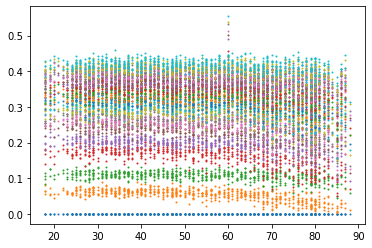

In [12]:
# Scatterplot of eigenvalues by age
# FIX THIS: This changes the variable name 'harmonics' and causes errors. Since writing this I've changed
# the code. I think I can use just graphs. 

for harmonic in range(20):
    harmonics = []
    for i in range(len(graphs)):
        harmonics.append(graphs[i].e[harmonic])
    plt.scatter(sorted_ages, harmonics, s=1)


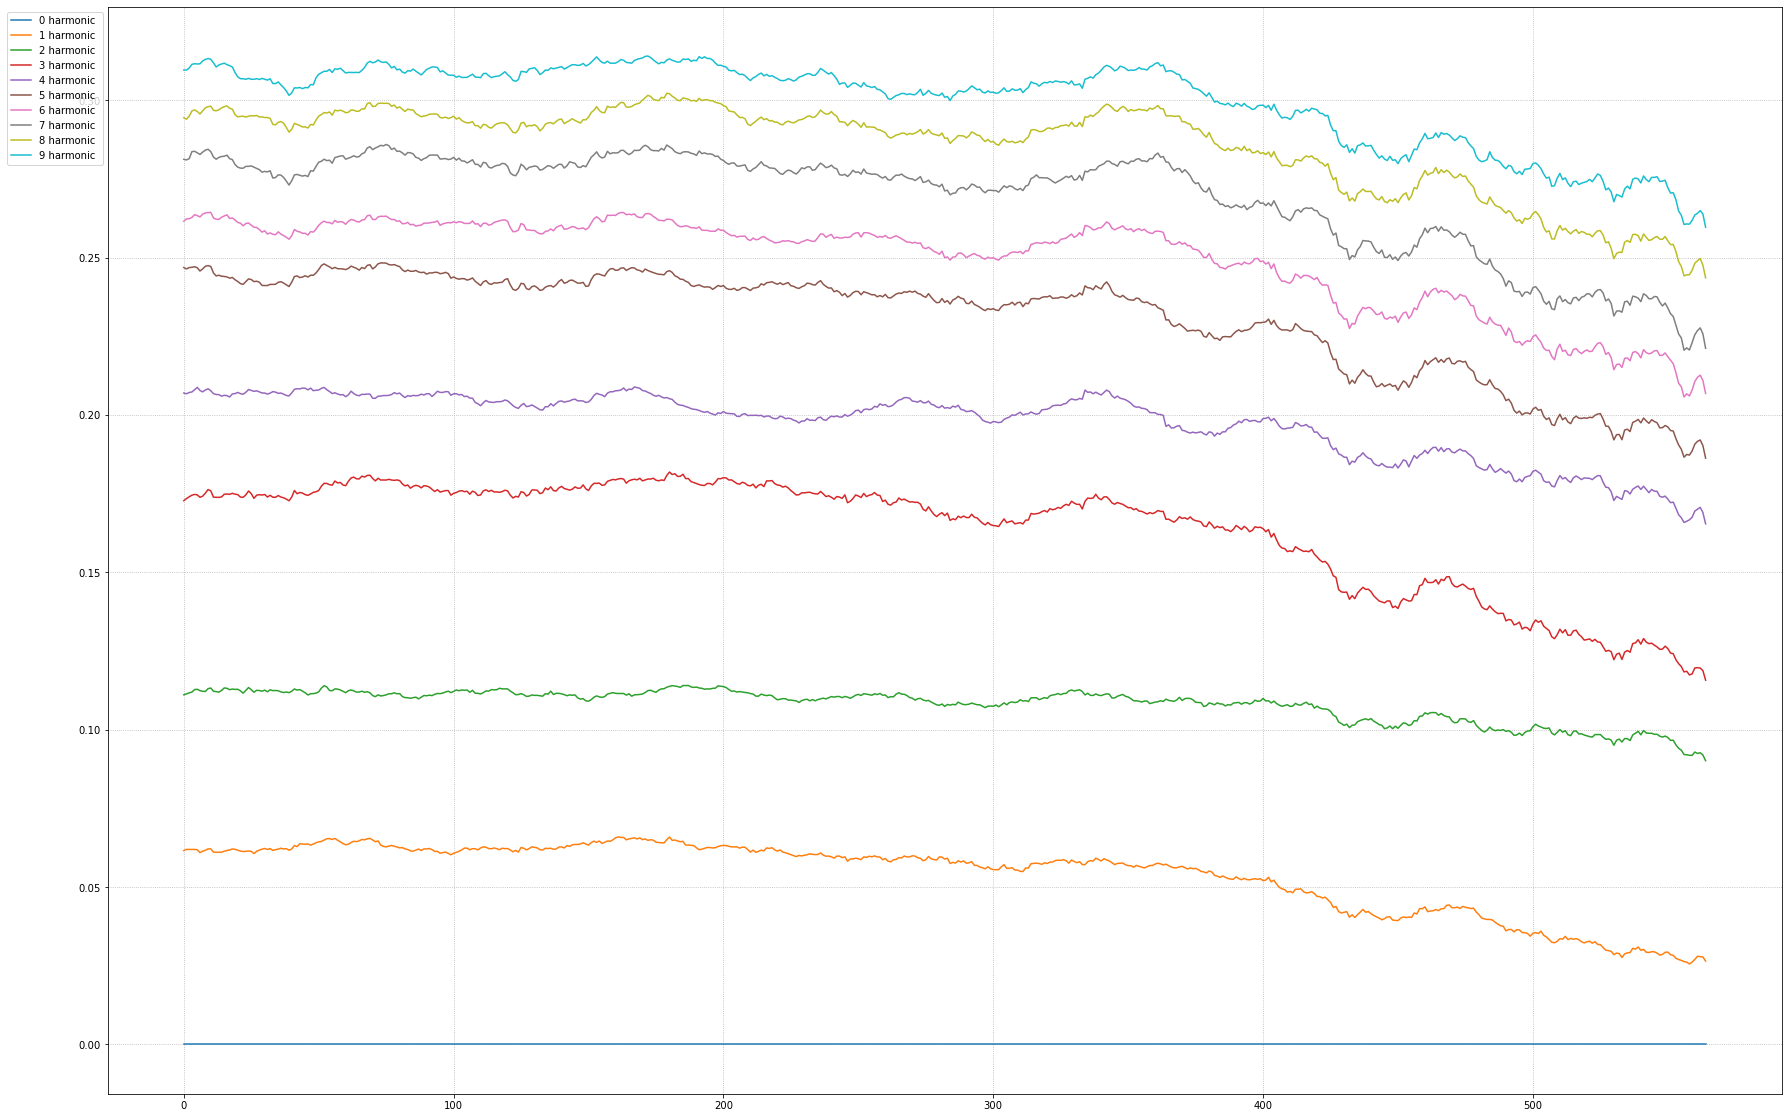

In [41]:

# takes a moving average of each harmonic's eigenvalue vs age. 
# the window variable controls how many subjects to average over to smooth the line

# I think this looks choppy because there are multiple participants for each age, so the 
# plot tries to use multiple values for each age

window = 30

average_y = []
plt.figure(figsize=(30, 20))

for harmonic in range(10):
    harmonics = []
    average_y = []
    for i in range(len(graphs)):
        harmonics.append(graphs[i].e[harmonic])

    # print(len(harmonics))

    for ind in range(len(harmonics) - window + 1):
        average_y.append(np.mean(harmonics[ind:ind+window]))

    # for j in range(window - 1):
    #     average_y.append(0)

    # print(len(average_y))
    # plt.plot(range(len(graphs)), harmonics, label=f'{harmonic}')
    plt.plot(range(len(graphs) - (window - 1)), average_y, label=f'{harmonic} harmonic ')
    # plt.plot(sorted_ages, average_y, label=f'{harmonic} harmonic')


plt.grid(linestyle=':')
plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1)
plt.show()



In [34]:
G_fd.e


array([0.        , 0.01050669, 0.05983818, 0.07010308, 0.09237769,
       0.11526754, 0.12718273, 0.13537899, 0.16562504, 0.1798689 ,
       0.19715804, 0.22134357, 0.22191841, 0.24038988, 0.26206277,
       0.26767467, 0.27756102, 0.28778219, 0.30966312, 0.31501973,
       0.32126436, 0.33442713, 0.35342706, 0.37319044, 0.37792445,
       0.39533512, 0.39834286, 0.40503561, 0.41661741, 0.41851581,
       0.42479342, 0.42931304, 0.45128513, 0.46086558, 0.46890456,
       0.47378962, 0.48249844, 0.48992862, 0.49200644, 0.49723388,
       0.49816711, 0.51393559, 0.52070674, 0.52868436, 0.5433866 ,
       0.55932287, 0.56392218, 0.57223353, 0.57690778, 0.58548822,
       0.58790403, 0.59273178, 0.60650464, 0.60750711, 0.61117535,
       0.61627136, 0.62345801, 0.63676017, 0.63905839, 0.64754231,
       0.65465633, 0.6611434 , 0.66446662, 0.67102123, 0.67328433,
       0.68136938, 0.68295058, 0.69282745, 0.69508125, 0.69544568,
       0.71396028, 0.71728372, 0.71830853, 0.72777178, 0.73390

### Plot the intervals between harmonics

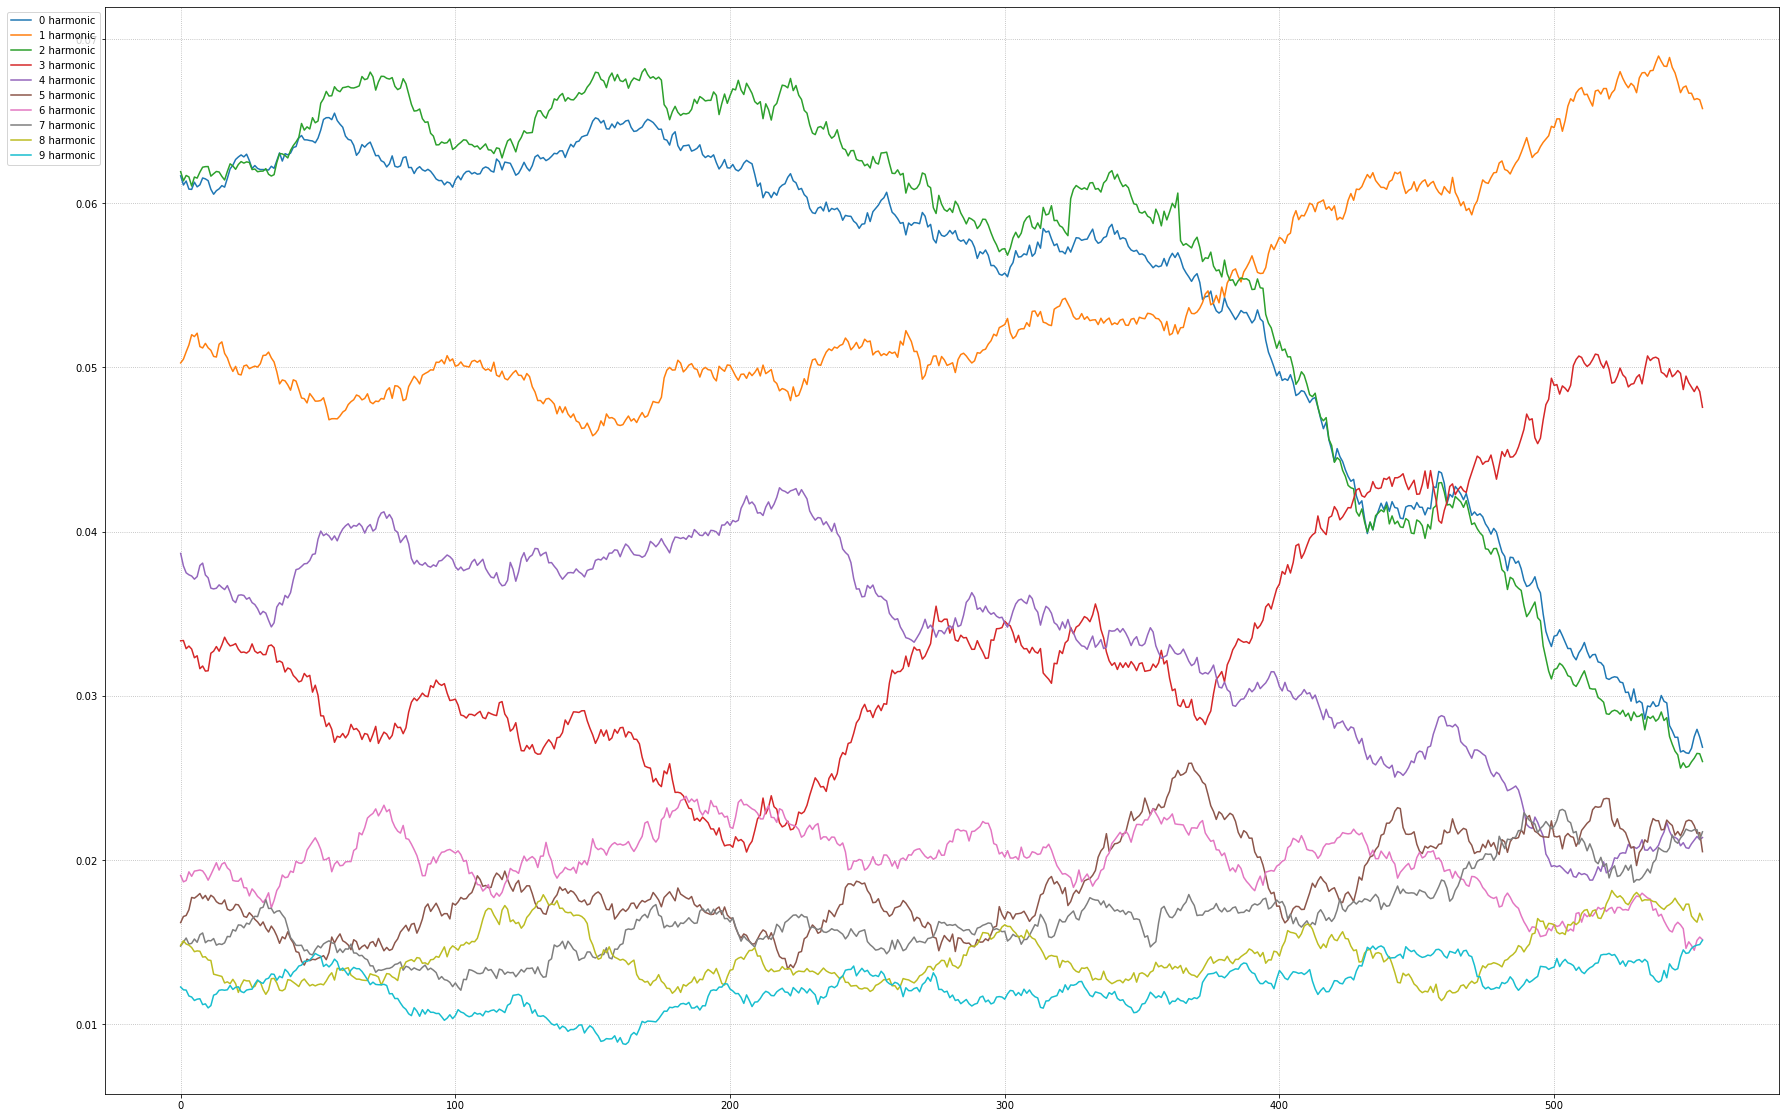

In [37]:

# takes a moving average of each harmonic's eigenvalue vs age. 
# the window variable controls how many subjects to average over to smooth the line

window = 40

average_y = []
plt.figure(figsize=(30, 20))

for harmonic in range(10):
    harmonics = []
    average_y = []

    for i in range(len(graphs)):
        harmonics.append(graphs[i].e[harmonic + 1] - graphs[i].e[harmonic])


    for ind in range(len(harmonics) - window + 1):
        average_y.append(np.mean(harmonics[ind:ind+window]))

    # for j in range(window - 1):
    #     average_y.append(0)


    # plt.plot(range(len(graphs)), average_y, label=f'{harmonic} harmonic ')
    plt.plot(range(len(graphs) - (window - 1)), average_y, label=f'{harmonic} harmonic')
    # plt.plot(range(len(graphs)), harmonics, label=f'{harmonic} harmonic')


plt.grid(linestyle=':')
plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1)
plt.show()



In [15]:
# Create color map to handle zeros with log visualization

custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))
# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))
# sns.heatmap(G_fd.U, cmap = custom_cmap, norm=LogNorm())
# sns.heatmap(G_fd.U, cmap = custom_cmap)

#sns.heatmap(G_fd.U[:,:20], cmap = custom_cmap,yticklabels=label[label.columns[2]].values)
sns.heatmap(harmonics[3,:,:20], cmap = custom_cmap,yticklabels=label[label.columns[2]].values)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
from pygsp import graphs, plotting
G_fd.set_coordinates()  # spring form plotting
G_fd.plot() 


In [ ]:
G_fd.plot_spectrogram()